# Modify Parameters and Run CFE Simulation in the Cloud

**Authors**

- Tony Castronova: acastronova@cuahsi.org
- Irene Garousi-Nejad: igarousi@cuahsi.org
- Scott Black: sblack@cuahsi.org

**Last Updated:** 05.28.2023

**Description**

This notebook demonstrates how to build and execute scientific workflows in the cloud using cyberinfrastructure developed as part of the "HydroShare Modernization" CIROH research project. The goal is do illustrate how the general-purpose cloud analysis workflows that have been developed to support common data archival operations, can also be leveraged for scientific computing. This notebook describes the process for using the outcomes of the aforementioned CIROH project, however these capabilities are still under active development are not ready for wide-spread public use.


**Data Availability**

This notebook requires access to the complete hydrological simulation inputs and outputs.

**Computational Availability**

This notebook leverages advanced cyberinfrastructure that is currently under active development. It has been made available to attendees that the 2024 CIROH User and Developer Conference, however it is not currently available to the general public. Access to this system may be terminated without notice.


**Software Requirements**

- git+https://github.com/CUAHSI/argo-workflow-python-client.git
- geopandas-0.14.4
- fiona-1.9.6
- numpy-1.26.4
- pandas-2.2.2
- pyproj-3.6.1
- shapely-2.0.4
- ipyleaflet-0.19.1
- sidecar-0.7.0
- fsspec-2024.5.0
- s3fs-2024.5.0
- pandas-2.2.1

In [7]:
!pip install git+https://github.com/CUAHSI/argo-workflow-python-client.git | tail -n 1

import swagger_client

  Running command git clone --filter=blob:none --quiet https://github.com/CUAHSI/argo-workflow-python-client.git /tmp/pip-req-build-c9svnmo9


In [8]:
!pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


In [9]:
from datetime import datetime
import geopandas
from helpers import ArgoAPI, SideCarMap
import fiona
import fsspec
import ipyleaflet
import pandas as pd

#!pip install -q matplotlib xarray
import utils

### Access data on Minio and Preview Domain Parameters

Bring the outputs of the last code cell from Demo 1.

In [10]:
bucket_name="scratch"
data_path="igarousi/wb-2854029/run-cfe-complete-new-path-bbfnj/"
MinIO_Path = "https://console.minio.cuahsi.io/browser/scratch/igarousi/wb-2854029/run-cfe-complete-new-path-bbfnj/"
Outlet_catchment_id="cat-2854029"
Outlet_nexus_id="nex-2854030"

print(MinIO_Path)

https://console.minio.cuahsi.io/browser/scratch/igarousi/wb-2854029/run-cfe-complete-new-path-bbfnj/


Initialize a filesystem object using the `fsspec` library, which provides a unified API for working with various file systems.

In [11]:
endpoint_url = 'https://api.minio.cuahsi.io'
fs = fsspec.filesystem('s3', client_kwargs={'endpoint_url': endpoint_url}, anon=True)

Access and read various domain-related data files stored in an S3 bucket using the `fsspec` library to interact with the S3 storage, and `geopandas` and `pandas` libraries to read geographic data.

In [12]:
# path to the data stored in an S3 bucket (full s3 url)
base_path = f's3://{bucket_name}/{data_path}'

# Define path to domain data
catchments_path = base_path + 'domain/' + 'catchments.geojson'
attributes_path = base_path + 'domain/' + 'cfe_noahowp_attributes.csv'
flowpaths_path = base_path + 'domain/' + 'flowpaths.geojson'
nexus_path = base_path + 'domain/' + 'nexus.geojson'
gpkg_path = base_path + 'domain/' + f'{data_path.split("/")[1]}_upstream_subset.gpkg'

# Read data
catchments = geopandas.read_file(fs.open(catchments_path))
flowpaths = geopandas.read_file(fs.open(flowpaths_path))
nexus = geopandas.read_file(fs.open(nexus_path))
attributes = pd.read_csv(fs.open(attributes_path))  # cfe_noahowp_attributes.csv

with fs.open(gpkg_path) as f:
    gdf_flow = geopandas.read_file(f, layer='flowpaths')
    f.seek(0)  # Reset file pointer
    gdf_cat = geopandas.read_file(f, layer='divides')
    f.seek(0)  # Reset file pointer
    gdf_nexus = geopandas.read_file(f, layer='nexus')

Print catchments and attributes data

In [13]:
catchments.columns

Index(['id', 'divide_id', 'toid', 'type', 'ds_id', 'areasqkm', 'lengthkm',
       'tot_drainage_areasqkm', 'has_flowline', 'geometry'],
      dtype='object')

In [14]:
attributes.columns

Index(['divide_id', 'elevation_mean', 'slope_mean', 'impervious_mean',
       'aspect_c_mean', 'twi_dist_4', 'X', 'Y', 'gw_Coeff', 'gw_Zmax',
       'gw_Expon', 'bexp_soil_layers_stag=1', 'bexp_soil_layers_stag=2',
       'bexp_soil_layers_stag=3', 'bexp_soil_layers_stag=4', 'ISLTYP',
       'IVGTYP', 'dksat_soil_layers_stag=1', 'dksat_soil_layers_stag=2',
       'dksat_soil_layers_stag=3', 'dksat_soil_layers_stag=4',
       'psisat_soil_layers_stag=1', 'psisat_soil_layers_stag=2',
       'psisat_soil_layers_stag=3', 'psisat_soil_layers_stag=4', 'cwpvt',
       'mfsno', 'mp', 'quartz_soil_layers_stag=1', 'quartz_soil_layers_stag=2',
       'quartz_soil_layers_stag=3', 'quartz_soil_layers_stag=4', 'refkdt',
       'slope', 'smcmax_soil_layers_stag=1', 'smcmax_soil_layers_stag=2',
       'smcmax_soil_layers_stag=3', 'smcmax_soil_layers_stag=4',
       'smcwlt_soil_layers_stag=1', 'smcwlt_soil_layers_stag=2',
       'smcwlt_soil_layers_stag=3', 'smcwlt_soil_layers_stag=4', 'vcmx25'],
    

combine two DataFrames (`catchments` and `attributes`) based on a common column.

In [13]:
merged = catchments.merge(attributes, on='divide_id')

Let's now plot the histogram of a parameter of interest across the domain. Then, we will highlight a catchment of interest and show the value of the parameter for the selected catchment on the histogram. You can choose any catchment from merged['divide_id']. For example, we can use the outlet catchment ID referenced in Demo 1.

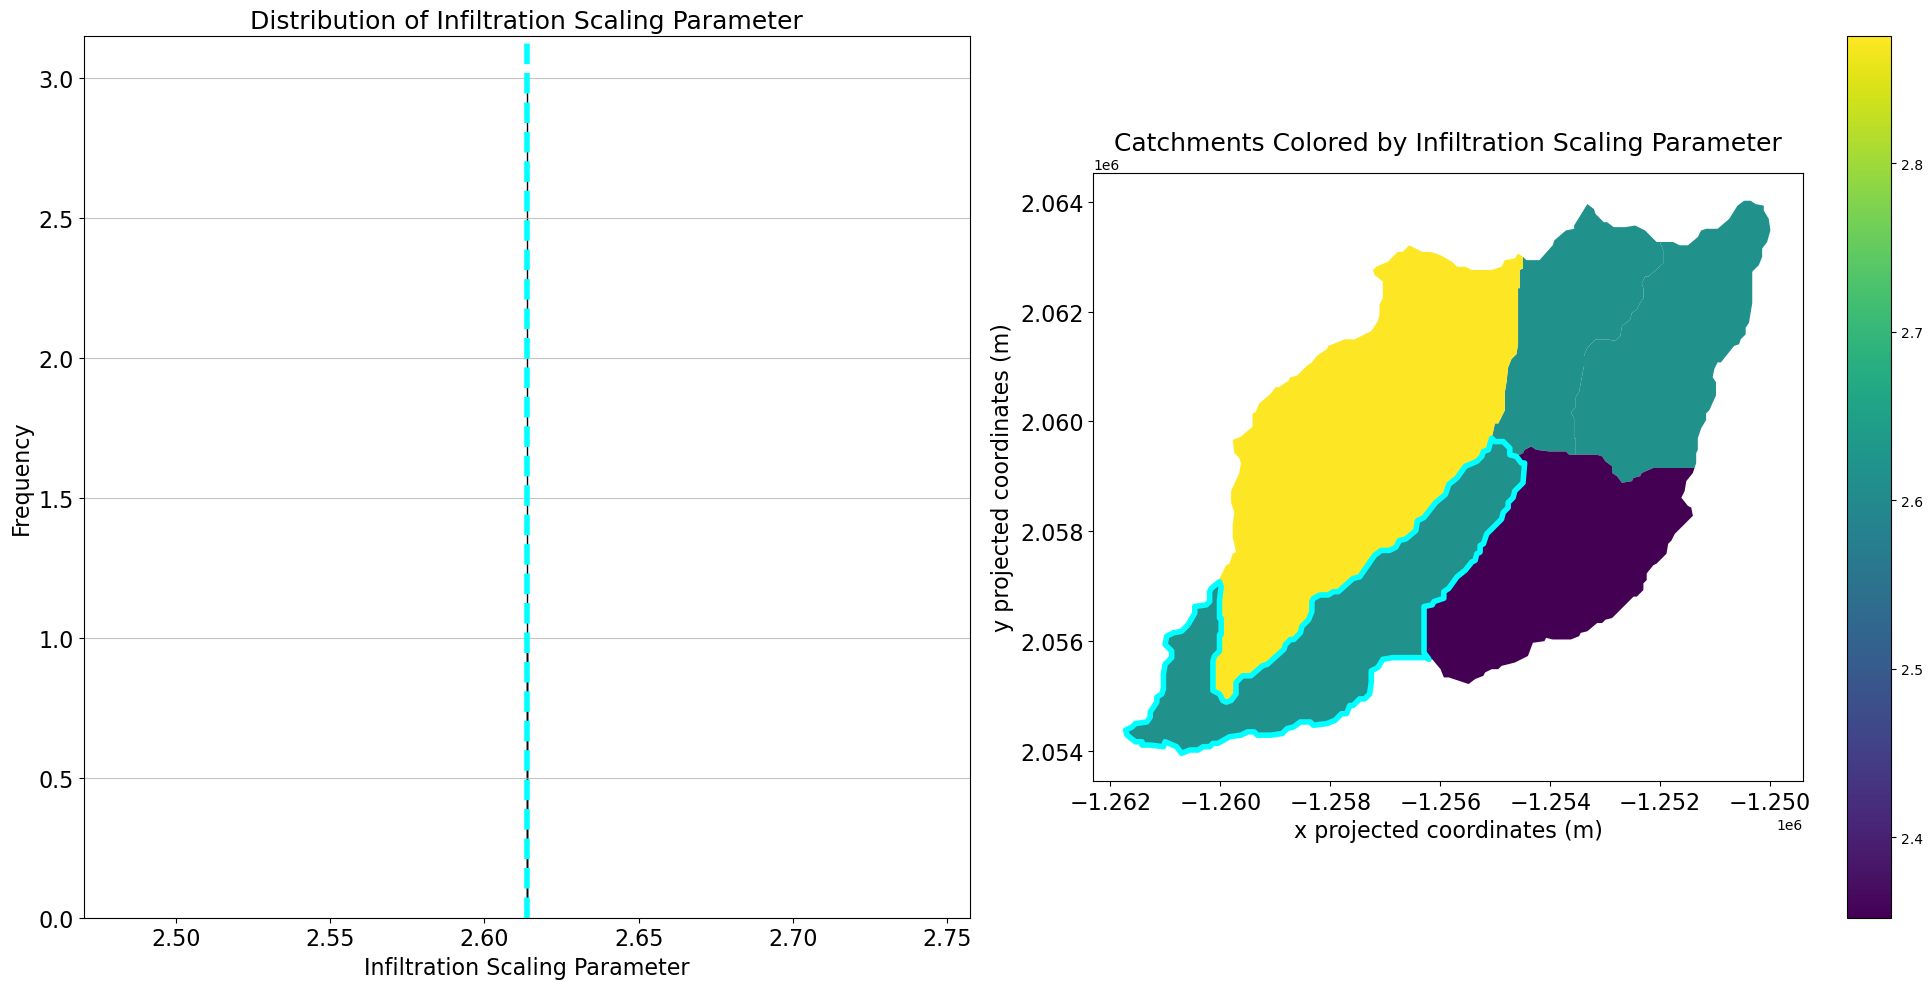

In [14]:
param = 'refkdt'                      # reference hydraulic conductivity
cat = Outlet_catchment_id              # catchment ID

utils.plot_single_cat(merged, param, 'Infiltration Scaling Parameter', 'viridis', cat)

Print the parameter value for the catchment of interest

In [10]:
print(f'{param} for {cat}: {merged.loc[merged["divide_id"]==cat].refkdt.values[0]}')

refkdt for cat-2854029: 2.613785982131958


We can also find this value in the configuration file for the selected catchment.

In [11]:
config_path = base_path + 'config/' +  f'{cat}_config.ini'
config_dict = utils.load_config(config_path, endpoint_url, fs)
config_dict

{'forcing_file': 'BMI',
 'soil_params.depth': '2.0[m]',
 'soil_params.b': '2.5787949562072754[]',
 'soil_params.satdk': '6.240216757033957e-07[m s-1]',
 'soil_params.satpsi': '0.0614453639118119[m]',
 'soil_params.slop': '0.3748068213462829[m/m]',
 'soil_params.smcmax': '0.5242637966746748[m/m]',
 'soil_params.wltsmc': '0.0604261664943055[m/m]',
 'refkdt': '0',
 'soil_params.expon': '1.0[]',
 'soil_params.expon_secondary': '0.005[]',
 'max_gw_storage': '122.64931488[m]',
 'Cgw': '0.0018[m h-1]',
 'expon': '6.0[]',
 'gw_storage': '0.05[m/m]',
 'alpha_fc': '0.33[]',
 'soil_storage': '0.05[m/m]',
 'K_nash': '0.03[]',
 'K_lf': '0.01[]',
 'nash_storage': '0.0,0.0',
 'giuh_ordinates': '1.0,0.0',
 'num_timesteps': '1',
 'verbosity': '0',
 'surface_partitioning_scheme': 'Schaake'}

### Modify Parameters

**refkdt** is actually runoff/infiltration rate and you can learn more about it in this article. This parameter is manually calibrated over multiple simulations and significantly impacts surface infiltration and hence the partitioning of total runoff into surface and subsurface runoff. <strong>Increased values of REFKDT leads to more infiltration and less surface runoff.

In [37]:
# change the value
var_name = 'refkdt'
var_value = '0'
utils.change_config(fs, config_path, config_dict, var_name, var_value)

Configuration updated successfully.


In [38]:
# view changes
config_dict = utils.load_config(config_path, endpoint_url, fs)
config_dict

{'forcing_file': 'BMI',
 'soil_params.depth': '2.0[m]',
 'soil_params.b': '2.5787949562072754[]',
 'soil_params.satdk': '6.240216757033957e-07[m s-1]',
 'soil_params.satpsi': '0.0614453639118119[m]',
 'soil_params.slop': '0.3748068213462829[m/m]',
 'soil_params.smcmax': '0.5242637966746748[m/m]',
 'soil_params.wltsmc': '0.0604261664943055[m/m]',
 'refkdt': '0',
 'soil_params.expon': '1.0[]',
 'soil_params.expon_secondary': '0.005[]',
 'max_gw_storage': '122.64931488[m]',
 'Cgw': '0.0018[m h-1]',
 'expon': '6.0[]',
 'gw_storage': '0.05[m/m]',
 'alpha_fc': '0.33[]',
 'soil_storage': '0.05[m/m]',
 'K_nash': '0.03[]',
 'K_lf': '0.01[]',
 'nash_storage': '0.0,0.0',
 'giuh_ordinates': '1.0,0.0',
 'num_timesteps': '1',
 'verbosity': '0',
 'surface_partitioning_scheme': 'Schaake'}

### Submit jobs

In [12]:
# set argo token, obtained from https://workflows.argo.cuahsi.io/userinfo 
ARGO_TOKEN='Bearer v2:eyJhbGciOiJSU0EtT0FFUC0yNTYiLCJlbmMiOiJBMjU2R0NNIiwiemlwIjoiREVGIn0.BAZ_kMidDBR1OMbwowo7PrnU2ltxAU8g4SBSEqSVfq816fJhUDdm79GVsGV89sygwidZoNXyOTmgFECDxVdng_8Y53YrNBF4yOchGpDNMA-mcL2BJaSibX4eRBS0vK9tb3wB8y_jpqKfHqpoZvPAwwx81eXr9mPHOZyKsQPq9H4UJOML-dp6lL0Mju83KiU5spfOqcDdHlo68AWlpEgODbj2-gPGU4527CIftFcQvKr3-ivcwIELTFV1cgFsBfo0WIxPplziFoA3QM_A8HSFqeEjL7JUeHTQuxvdKqaflWK96G2XyBTohU6FaJYIfzv1EFMvMhkznobaL33gmZKhkg.dq8BxpF9kYFN4MSP.Z2iMGyEkFlOy7wdzvgHXya9xX_U75TajM93lDncadAXt7Z22s4dbehlhw_gAZSdYLjNIfuUmJawYRniae4NvYtxYdg90j6dcUDTuLS9ju_ixaJMgenlLp6G0_VyLA7_bEG_4AAW-Ku-8xw0T0fve359E3mTbASXonp-neNgBZm4ZEiMuHs8f2R3B78x6_PL_37Q8uCmC1INRAftC8pWDpVAFUeDXduHBcPYTMhzhqOjU80110BOk9jSQjVV8KkmObJ5SDFxx4jzOLYBQV4ZuvlPe9KQ.-xey8NemMURhtZgL62qYmA'

In [13]:
# create an instance of ArgoAPI using our ARGO_TOKEN
argo = ArgoAPI(ARGO_TOKEN)

User Info
╭────────┬─────────────────────╮
│ Status │ Connected           │
│ Name   │ Irene Garousi-Nejad │
│ Email  │ igarousi@cuahsi.org │
╰────────┴─────────────────────╯


In [14]:
# display the metadata for the workflow
argo.display_workflow_metadata('ngen-run')

╭─────────────┬─────────────────────────────────────────────────────────────────────────────────╮
│ Key         │ Value                                                                           │
├─────────────┼─────────────────────────────────────────────────────────────────────────────────┤
│ description │ The workflow executes an NGEN model simulation using the CIROH NextGen in a Box │
│             │ (NGIAB) service. Model simulations are executed in serial using the 'ngen-      │
│             │ serial' command within the awiciroh/ciroh-ngen-image:latest-x86 docker image.   │
│ longname    │ Execute NextGen in a Box (NGIAB)                                                │
│ version     │ 0.1                                                                             │
╰─────────────┴─────────────────────────────────────────────────────────────────────────────────╯


In [15]:
# display the workflow parameter metadata
argo.display_workflow_parameters('ngen-run')

╭───────────────────────┬───────────────────────────┬──────────────────────────────────────────────────────────────────────────────────╮
│ Variable              │ Default                   │ Description                                                                      │
├───────────────────────┼───────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ input-data-bucket     │ acastronova               │ Name of the cloud bucket that contains simulation input data.                    │
│ input-data-path       │ wb-2917533                │ Relative path within the 'input-data-bucket' that points to the root simulation  │
│                       │                           │ directory.                                                                       │
│ catchment-file-path   │ domain/catchments.geojson │ Path relative to the 'input-data-path' pointing to the catchments.geojson input  │
│                       │                

To run this workflow, we need to provide values for each of the input parameters listed above. In this example, the `input bucket` and `input data path` refer to the data that has already been subsetted, prepared, and used in Demo 1, which is stored on Minio S3. The `output bucket` is the same as the input bucket because we want to save the results in the same location. However, we will save the model outputs of the new simulation in a new `out put path` to prevent overwriting the results from Demo 1. This approach allows us to compare the results and see the impact of our modifications to the parameter of interest.

In [17]:
parameters = {
    "input-data-bucket": bucket_name,
    "input-data-path": data_path,
    "catchment-file-path": "domain/catchments.geojson",
    "nexus-file-path": "domain/nexus.geojson",
    "realization-file-path": "config/realization.json",
    "output-bucket": bucket_name,
    "output-path": data_path+f'{cat}_{param}_0',
}

parameters

{'input-data-bucket': 'scratch',
 'input-data-path': 'igarousi/wb-2854029/run-cfe-complete-new-path-bbfnj/',
 'catchment-file-path': 'domain/catchments.geojson',
 'nexus-file-path': 'domain/nexus.geojson',
 'realization-file-path': 'config/realization.json',
 'output-bucket': 'scratch',
 'output-path': 'igarousi/wb-2854029/run-cfe-complete-new-path-bbfnj/cat-2854029_refkdt_0'}

In [18]:
job_name = argo.submit_workflow('ngen-run', parameters)
job_name

'ngen-run-cm5kf'

In [24]:
w = argo.workflow_api_instance.workflow_service_get_workflow(argo.namespace, job_name)

def get_node(name):
    return w.status.nodes[name]
    
def print_status(name, formatting=''):
    node = get_node(name)
    print(node.display_name)
    if node.display_name[-3:] == '(0)':    
        pass
    elif node.phase == 'Succeeded':
        st = datetime.strptime(node.started_at, '%Y-%m-%dT%H:%M:%SZ')
        et = datetime.strptime(node.finished_at, '%Y-%m-%dT%H:%M:%SZ')
        print(f'{formatting}{node.display_name}: {node.phase} -> {(et-st).total_seconds():.2f} seconds')
    else:
        print(f'{formatting}{node.display_name}: {node.phase}')
    if node.display_name[-3:] != '(0)':    
        children = node.children
        if children is not None:
            # formatting += ' '
            for child in children:
                c = get_node(child)
                print_status(child, formatting=formatting)

print(f'View the Workflow Here: https://workflows.argo.cuahsi.io/workflows/workflows/{job_name}')
print_status(job_name)

View the Workflow Here: https://workflows.argo.cuahsi.io/workflows/workflows/ngen-run-cm5kf
ngen-run-cm5kf
ngen-run-cm5kf: Succeeded -> 86.00 seconds
ngen-run-cm5kf(0)


To preview the output data that our job created, we need to first construct the url to our output data. Our output path use our hydroshare username so that we can easily find it.

In [41]:
print(f'Browse the output files at:')
print(f'https://console.minio.cuahsi.io/browser/{bucket_name}/{data_path}{cat}_{param}_0')

Browse the output files at:
https://console.minio.cuahsi.io/browser/scratch/igarousi/wb-2854029/run-cfe-complete-new-path-bbfnj/cat-2854029_refkdt_0


In [16]:
from pathlib import Path

url = f's3://{bucket_name}/{data_path}'
print(url)

# connect to the CUAHSI MinIO server that is hosting our data
s3 = fsspec.filesystem("s3",
                       anon=True,
                       client_kwargs={'endpoint_url':'https://api.minio.cuahsi.io'},
                       use_listings_cache=False,
                      )

def pretty_list(url, indent_count=0):
    items = s3.listdir(url)
    for item in items:
        if item['type'] == 'directory':
            indent = ' '*indent_count
            name = Path(item['name']).name
            print(f'{indent}+ {name}')
            next_indent_count = indent_count + 1
            pretty_list(item['Key'], next_indent_count)
        else:
            if item['type'] == 'file':
                indent = ' '*indent_count
                name = Path(item['name']).name
                print(f'{indent}- {name}')

s3://scratch/igarousi/wb-2854029/run-cfe-complete-new-path-bbfnj/


In [37]:
pretty_list(url)

+ cat-2854029_refkdt_0
 + results
  - cat-2854027.csv
  - cat-2854028.csv
  - cat-2854029.csv
  - cat-2854031.csv
  - cat-2854032.csv
  - nex-2854028_output.csv
  - nex-2854029_output.csv
  - nex-2854030_output.csv
+ config
 - cat-2854027_config.ini
 - cat-2854028_config.ini
 - cat-2854029_config.ini
 - cat-2854031_config.ini
 - cat-2854032_config.ini
 - ngen.yaml
 - realization.json
+ domain
 - catchments.geojson
 - cfe_noahowp_attributes.csv
 - crosswalk.json
 - flowpath_edge_list.json
 - flowpaths.geojson
 - nexus.geojson
 - watershed.gz
 - wb-2854029_upstream_subset.gpkg
+ forcing
 - cat-2854027.csv
 - cat-2854028.csv
 - cat-2854029.csv
 - cat-2854031.csv
 - cat-2854032.csv
 - forcing.nc
+ results
 - cat-2854027.csv
 - cat-2854028.csv
 - cat-2854029.csv
 - cat-2854031.csv
 - cat-2854032.csv
 - nex-2854028_output.csv
 - nex-2854029_output.csv
 - nex-2854030_output.csv


### Preview Simulation Results

In [17]:
forcing_path = f'{url}forcing'
base_results_path = f'{url}results'
mod_results_path = f'{url}{cat}_{param}_0/results'
print(f'forcing_path: {forcing_path}\nbase results_path: {base_results_path}\nmodified_results_path: {mod_results_path}')

forcing_path: s3://scratch/igarousi/wb-2854029/run-cfe-complete-new-path-bbfnj/forcing
base results_path: s3://scratch/igarousi/wb-2854029/run-cfe-complete-new-path-bbfnj/results
modified_results_path: s3://scratch/igarousi/wb-2854029/run-cfe-complete-new-path-bbfnj/cat-2854029_refkdt_0/results


In [18]:
############# load data from Demo 1 (base simulation)
forcing_csv_files = s3.glob(f'{forcing_path}/cat*.csv')
base_nex_csv_files = s3.glob(f'{base_results_path}/nex*.csv')
base_cat_csv_files = s3.glob(f'{base_results_path}/cat*.csv')
base_forcing_xr = utils.forcing_csv2xr(s3, forcing_csv_files)   # convert csv to xarray
base_nex_xr =  utils.nex_csv2xr(s3, base_nex_csv_files)         # convert csv to xarray 
base_cat_xr = utils.cat_csv2xr(s3, base_cat_csv_files)          # convert csv to xarray 

############# load data from Demo 2 (modify parameters)
mod_nex_csv_files = s3.glob(f'{mod_results_path}/nex*.csv')
mod_cat_csv_files = s3.glob(f'{mod_results_path}/cat*.csv')
mod_nex_xr =  utils.nex_csv2xr(s3, mod_nex_csv_files)           # convert csv to xarray
mod_cat_xr = utils.cat_csv2xr(s3, mod_cat_csv_files)            # convert csv to xarray

Create a plot of input preciptation and simulated streamflow for the base (Demo 1) and test (Demo 2) scenarios.

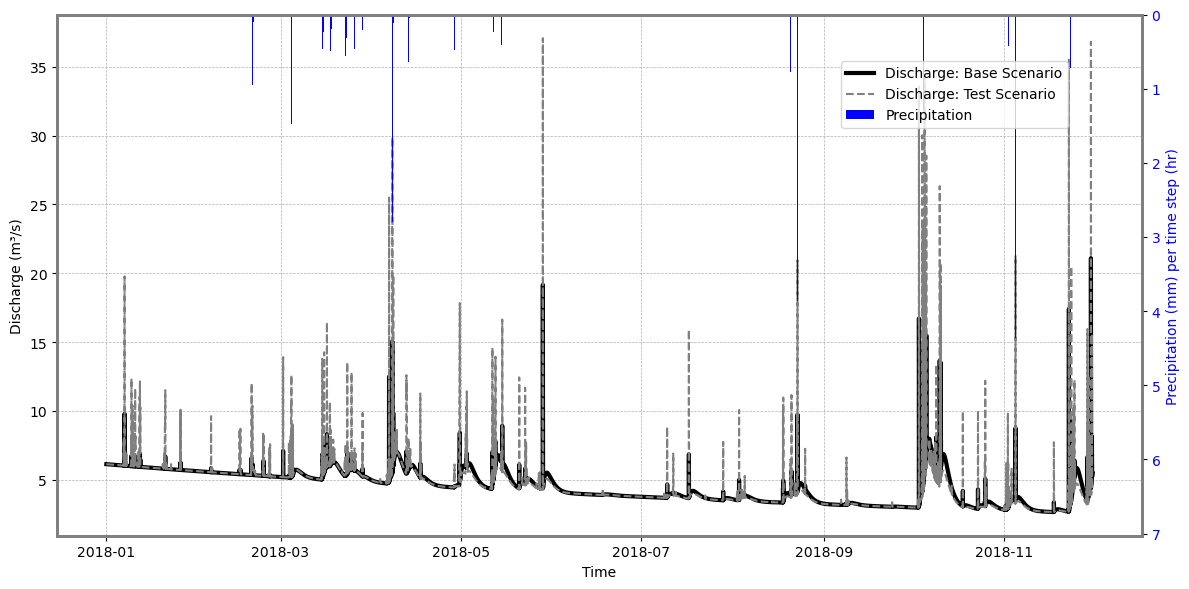

In [19]:
utils.plot_flow_comparison(Outlet_catchment_id, Outlet_nexus_id, 
                         base_forcing_xr, base_nex_xr, base_cat_xr, 
                         mod_nex_xr, mod_cat_xr)

In [20]:
# save xarray datasets as netcdf files to your local environment
base_forcing_xr.to_netcdf('./forcing.nc')
base_nex_xr.to_netcdf('./base_simulation_nexus_results.nc')
base_cat_xr.to_netcdf('./base_simulation_cat_results.nc')
mod_nex_xr.to_netcdf('./test_simulation_xr_results.nc') 
mod_cat_xr.to_netcdf('./test_simulation_cat_results.nc') 


Upload files to the S3-compatible object storage service where your model inputs and outputs are stored. Currently, we have set `signature_version=UNSIGNED`, which means you do not require authentication and can use unsigned requests.

In [54]:
import os
import boto3
import glob
from botocore import UNSIGNED
from botocore.client import Config

s3 = boto3.client('s3', endpoint_url="https://api.minio.cuahsi.io", config=Config(signature_version=UNSIGNED))

for file in glob.glob('./*.nc'):
    s3.upload_file(file, bucket_name, f'{data_path}post_process/{os.path.basename(file)}')

print(f'https://console.minio.cuahsi.io/browser/{bucket_name}/{data_path}')

https://console.minio.cuahsi.io/browser/scratch/igarousi/wb-2854029/run-cfe-complete-new-path-bbfnj/


### Share Results on HydroShare

Save the data of the modeling and analysis results on HydroShare. Use the HydroShare Python Client (hsclient), a library that allows users to interact with HydroShare, to create a new resource for your analysis datasets. For more information, see the [hsclient GitHub page](https://github.com/hydroshare/hsclient) and this [HydroShare resource](https://www.hydroshare.org/resource/7561aa12fd824ebb8edbee05af19b910/).

In [85]:
from hsclient import HydroShare

# sign in to the system using your HydroShare credentials
hs = HydroShare()
hs.sign_in()

# create a resource
res = hs.create()

# define metadata (including title, abstract, keywords)
res.metadata.title = 'Comparison of CFE Model Outputs to Assess the Impact of Modifying Soil Hydraulic Conductivity on Streamflow'
res.metadata.abstract = 'This resource provides links to the comparative analysis of two distinct CFE simulation scenarios. \
    The first scenario, referred to as the "base" scenario, utilizes default model parameters. \
    The second scenario, named the "test" scenario, uses a modified `refkdt` (reference hydraulic conductivity). \
    All relevant model inputs, configurations, outputs, and post-processing results for this comparative\
    analysis are sored in S3 storage.'
res.metadata.subjects = ['argo workflows', 'cfe model outputs', 'hydraulic conductivity', 'CIROH developers conference 2024']

# Call the save function to save the metadata edits to HydroShare
res.save()

# Creates a HydroShare reference object to reference content outside of the resource
res.reference_create("s3reference", MinIO_Path)


Username:  igarousi
Password for igarousi:  ········


In [86]:
print(f'Your new resource is available at: {res.metadata.url}')

Your new resource is available at: http://www.hydroshare.org/resource/7d67c2921378420881afda16fefbfa0b


Add more metadata

In [83]:
from hsmodels.schemas.fields import PeriodCoverage

# Create a beginning and ending date for a time period
beginDate = pd.to_datetime(base_forcing_xr.time[0].values)
endDate = pd.to_datetime(base_forcing_xr.time[-1].values)

# Set the temporal coverage of the resource to a PeriodCoverage object
res.metadata.period_coverage = PeriodCoverage(start=beginDate, end=endDate)

# Save the changes to the resource in HydroShare
res.save()
print(f'Your new resource is available at: {res.metadata.url}')

Your new resource is available at: http://www.hydroshare.org/resource/1968186bdb1b4317890522379b65c84b
